In [103]:
### IMPORTS ###
# Quantum libraries:
import pennylane as qml
from pennylane import numpy as np
import jax
import jax.numpy as jnp
from jax import jit
from functools import partial

# Plotting
from matplotlib import pyplot as plt

# Other
import copy
from tqdm.notebook import tqdm # Pretty progress bars
from IPython.display import Markdown, display # Better prints
import joblib # Writing and loading
from noisyopt import minimizeSPSA

import multiprocessing
##############

import vqe_functions as vqe

#   _    
#  / |   
#  | |   
#  | |_  
#  |_(_) 

def num_params_qcnn(N):
    '''
    N = number of wires (spins)
    To evaluate the number of parameters needed for the qcnn
    a recursive function is needed:
    '''
    n_params = 0
    # While the number of wires is more than 1s
    while(N > 1):
        # Convolution
        n_params += 3*N
        # Pooling 
        n_params += 2*(N//2) + N%2
        # Reduce number of wires due to pooling
        N = N // 2 + N % 2
    
    # Last RY gate
    n_params += 1
    
    return n_params

#  ____     
# |___ \    
#   __) |   
#  / __/ _  
# |_____(_) Circuit functions

def qcnn_convolution(active_wires, params, N, p_index, conv_noise = 0):
    '''
    Convolution block for the QCNN
    
    RX--RY--o--RX---------
            | 
    RX--RY--x------o--RX--
                   |
    RX--RY--o--RX--x------
            | 
    RX--RY--x------o--RX--
                   |
    RX--RY--o--RX--x------
            | 
    RX--RY--x---------RX--
    
    '''
    
    # Check if the current number of wires is odd
    # it will be needed later.
    isodd = True if len(active_wires) % 2 != 0  else False
    
    noise = True
    if conv_noise == 0: noise = False # Remove BitFlip and PhaseFlip if we are not using default.mixed
    
    # Convolution:
    for wire in active_wires:
        qml.RX(params[p_index],   wires = int(wire) )
        qml.RY(params[p_index+1], wires = int(wire) )
        p_index = p_index + 2
        
        if noise: qml.PhaseFlip(conv_noise, wires = int(wire) ); qml.BitFlip(conv_noise, wires = int(wire) )
        
    # ---- > Establish entanglement: odd connections
    for wire, wire_next in zip(active_wires[0::2], active_wires[1::2]):
        qml.CNOT(wires = [int(wire), int(wire_next)])
        qml.RX(params[p_index], wires = int(wire) )
        p_index = p_index + 1
        
        if noise: qml.PhaseFlip(conv_noise, wires = int(wire) ); qml.BitFlip(conv_noise, wires = int(wire) )
        
    # ---- > Establish entanglement: even connections
    for wire, wire_next in zip(active_wires[1::2], active_wires[2::2]):
        qml.CNOT(wires = [int(wire), int(wire_next)])
        qml.RX(params[p_index], wires = int(wire) )
        p_index = p_index + 1
        
        if noise: qml.PhaseFlip(conv_noise, wires = int(wire) ); qml.BitFlip(conv_noise, wires = int(wire) )
        
    qml.RX(params[p_index], wires = N-1)
    p_index = p_index + 1
    
    if noise: qml.PhaseFlip(conv_noise, wires = int(N - 1) ); qml.BitFlip(conv_noise, wires = int(N - 1) )

    return p_index
        
def qcnn_pooling(active_wires, params, N, p_index, pool_noise = 0):
    '''
    Pooling block for the QCNN
    
    --MEAS--(=0)--(=1)
             |     |
    ---------RY----RZ----
    
    '''
    # Pooling:
    isodd = True if len(active_wires) % 2 != 0  else False
    
    noise = True
    if pool_noise == 0: noise = False # Remove BitFlip and PhaseFlip if we are not using default.mixed
    
    for wire_meas, wire_next in zip(active_wires[0::2], active_wires[1::2]):
        m_0 = qml.measure(int(wire_meas) )
        qml.cond(m_0 ==0, qml.RY)(params[p_index], wires=int(wire_next) )
        qml.cond(m_0 ==1, qml.RZ)(params[p_index+1], wires=int(wire_next) )
        p_index = p_index + 1
        
        if noise: qml.PhaseFlip(pool_noise, wires = int(wire_next) ); qml.BitFlip(pool_noise, wires = int(wire_next) )
        
        # Removing measured wires from active_wires:
        active_wires = np.delete(active_wires, np.where(active_wires == wire_meas) ) 
    # ---- > If the number of wires is odd, the last wires is not pooled
    #        so we apply a Z gate
    if isodd:
        qml.RZ(params[p_index], wires = N-1)
        p_index = p_index + 1
        
        if noise: qml.PhaseFlip(pool_noise, wires = N - 1 ); qml.BitFlip(pool_noise, wires = N - 1 )
        
    return p_index, active_wires

def qcnn(params_vqe, vqe_shift_invariance, params, N, vqe_conv_noise = 0, vqe_rot_noise = 0, qcnn_conv_noise = 0, qcnn_pool_noise = 0):
    '''
    Building function for the circuit:
          VQE(params_vqe) + QCNN(params)
    '''
    # Check on the size of the parameters:
    if len(params) != num_params_qcnn(N):
        raise ValueError('Invalid size of parameters')
        
    # Wires that are not measures (through pooling)
    active_wires = np.arange(N)
    
    # Input: State through VQE
    vqe.circuit(N, params_vqe, vqe_shift_invariance, p_noise = vqe_rot_noise, p_noise_ent = vqe_conv_noise)
    
    qml.Barrier()
    
    # Index of the parameter vector
    p_index = 0
    
    while(len(active_wires) > 1):
        p_index = qcnn_convolution(active_wires, params, N, p_index, conv_noise = qcnn_conv_noise)
        qml.Barrier()
        p_index, active_wires = qcnn_pooling(active_wires, params, N, p_index, pool_noise = qcnn_pool_noise)
        qml.Barrier()
    
    # Final Y rotation
    qml.RY(params[p_index], wires = N-1)
    if qcnn_pool_noise > 0: qml.PhaseFlip(qcnn_pool_noise, wires = N - 1 ); qml.BitFlip(qcnn_pool_noise, wires = N - 1 )

#  _____   
# |___ /   
#   |_ \   
#  ___) |  
# |____(_) Learning functions

# Estimation functions for QCNN

def compute_accuracy(data, params, shift_invariance, N):
    corrects = 0 
    for datum in data:
        prediction = qcnn_circuit(datum[0], shift_invariance, params, N)
        if np.argmax( prediction ) == datum[1]:
            corrects += 1  
            
    return 100*corrects/len(data)

# Training function
def qcnn_training(epochs, lr, r_shift, vqe_shift_invariance, N, vqe_conv_noise, vqe_rot_noise, qcnn_conv_noise, qcnn_pool_noise,
                  X_train, Y_train, X_test = [], Y_test = [], plot = True):
    
    X_train, Y_train = np.array(X_train), np.array(Y_train)
    X_test, Y_test = np.array(X_test), np.array(Y_test)    
    
    display(Markdown('***Parameters:***'))
    
    # Initialize parameters randomly
    params = np.array( np.random.randn(num_params_qcnn(N)) )
    
    def update(X, Y, X_test, Y_test, pbar, params):
        cross_entropy = 0
        corrects = 0
        for x,y in zip(X,Y):
            prediction = qcnn_circuit(x, vqe_shift_invariance, params, N,
                                      vqe_conv_noise, vqe_rot_noise, qcnn_conv_noise, qcnn_pool_noise)
            
            cross_entropy += y * np.log(prediction[y]) + (1 - y) * np.log(1 - prediction[1 - y])
            
            if np.argmax( prediction ) == y:
                corrects += 1   
            
        loss_history.append( - cross_entropy )
        accuracy_history.append(100*corrects/len(Y)) 
        
        pbar.update()
        pbar.set_description('Cost: {0} | Accuracy: {1}'.format(loss_history[-1], accuracy_history[-1])  )
        
        return - cross_entropy

    spsa_callback = lambda v: update(X_train, Y_train, X_test, Y_test, pbar, v)

    loss_history = []
    accuracy_history = []
    #loss_history_test = []
    accuracy_history_test = []
    
    #with tqdm(total=epochs) as pbar:
    pbar = tqdm(total = 2*epochs+1)
    
    res = minimizeSPSA(spsa_callback,
                       x0=params,
                       niter=epochs,
                       paired=False,
                       c=r_shift,
                       a=lr)
    
    params = res.x
    
    if plot:
        plt.figure(figsize=(15,5))
        plt.plot(np.arange(len(loss_history))*10, np.asarray(loss_history), label = 'Training Loss')
       #if len(X_test) > 0:
            #plt.plot(np.arange(steps), np.asarray(loss_history_test)/len(X_test), color = 'green', label = 'Test Loss')
        plt.axhline(y=0, color='r', linestyle='--')
        plt.title('Loss history')
        plt.ylabel('Average Cross entropy')
        plt.xlabel('Epoch')
        plt.grid(True)
        plt.legend()
        
        plt.figure(figsize=(15,4))
        plt.plot(np.arange(len(accuracy_history))*10, accuracy_history, color='orange', label = 'Training Accuracy')
        if len(X_test) > 0:
            plt.plot(np.arange(len(accuracy_history))*10, accuracy_history_test, color='violet', label = 'Test Accuracy')
        plt.axhline(y=100, color='r', linestyle='--')
        plt.title('Accuracy')
        plt.ylabel('%')
        plt.xlabel('Epoch')
        plt.grid(True)
        plt.legend()
        
    return loss_history, accuracy_history, params

#  _  _     
# | || |    
# | || |_   
# |__   _|  
#    |_|(_) Visualization    

def plot_results_classification(data, train_index, params, vqe_shift_invariance, N, 
                                vqe_conv_noise = 0, vqe_rot_noise = 0, qcnn_conv_noise = 0, qcnn_pool_noise = 0):
    test_index = []
    for i in range(len(data)):
        if not i in train_index:
            test_index.append(i)
    
    predictions_train = []
    predictions_test  = []

    colors_train = []
    colors_test  = []

    for i in range(len(data)):
        prediction = qcnn_circuit(data[i][0], vqe_shift_invariance, params, N, vqe_conv_noise, vqe_rot_noise, qcnn_conv_noise, qcnn_pool_noise)
        prediction = prediction[1]
        #print(qcnn_fun(data[i][0], params))

        # if data in training set
        if i in train_index:
            predictions_train.append(prediction)
            if np.round(prediction) == 0:
                if i <= len(data)/2:
                    colors_train.append('green')
                else:
                    colors_train.append('red')
            else:
                if i <= len(data)/2:
                    colors_train.append('red')
                else:
                    colors_train.append('green')
        else:
            predictions_test.append(prediction)
            if np.round(prediction) == 0:
                if i <= len(data)/2:
                    colors_test.append('green')
                else:
                    colors_test.append('red')
            else:
                if i <= len(data)/2:
                    colors_test.append('red')
                else:
                    colors_test.append('green')
    
    fig, ax = plt.subplots(2, 1, figsize=(16,10))

    ax[0].set_xlim(-0.1,2.1)
    ax[0].set_ylim(0,1)
    ax[0].grid(True)
    ax[0].axhline(y=.5, color='gray', linestyle='--')
    ax[0].axvline(x=1, color='gray', linestyle='--')
    ax[0].text(0.375, .68, 'I', fontsize=24, fontfamily='serif')
    ax[0].text(1.6, .68, 'II', fontsize=24, fontfamily='serif')
    ax[0].set_xlabel('Transverse field')
    ax[0].set_ylabel('Prediction of label II')
    ax[0].set_title('Predictions of labels; J = 1')
    ax[0].scatter(2*np.sort(train_index)/len(data), predictions_train, c = 'royalblue', label='Training samples')
    ax[0].scatter(2*np.sort(test_index)/len(data), predictions_test, c = 'orange', label='Test samples')
    ax[0].legend()

    ax[1].set_xlim(-0.1,2.1)
    ax[1].set_ylim(0,1)
    ax[1].grid(True)
    ax[1].axhline(y=.5, color='gray', linestyle='--')
    ax[1].axvline(x=1, color='gray', linestyle='--')
    ax[1].text(0.375, .68, 'I', fontsize=24, fontfamily='serif')
    ax[1].text(1.6, .68, 'II', fontsize=24, fontfamily='serif')
    ax[1].set_xlabel('Transverse field')
    ax[1].set_ylabel('Prediction of label II')
    ax[1].set_title('Predictions of labels; J = 1')
    ax[1].scatter(2*np.sort(train_index)/len(data), predictions_train, c = colors_train)
    ax[1].scatter(2*np.sort(test_index)/len(data), predictions_test, c = colors_test)
    
    

In [105]:
compute_accuracy(data, params, 0, N)

98.0

***Parameters:***

  0%|          | 0/201 [00:00<?, ?it/s]

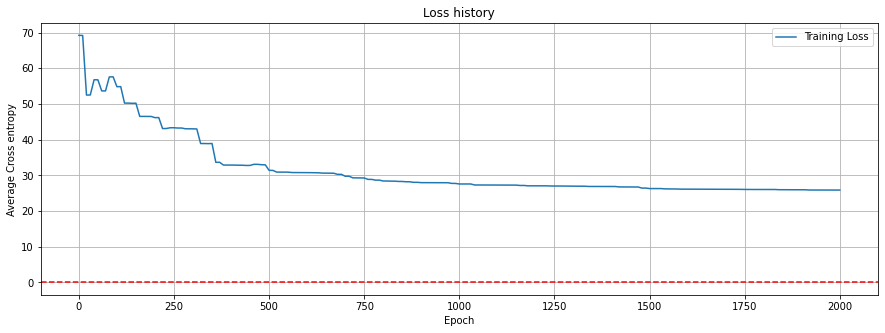

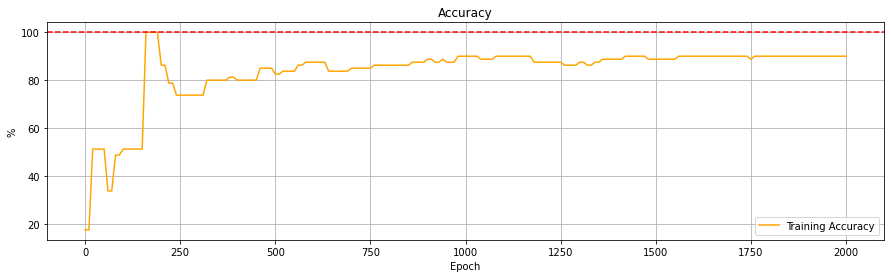

In [112]:
loss_history, accuracy_history, params = qcnn_training(100, 0.05, 0.0008, 0, N, 0.001, 0.001, 0.001, 0.001,
                                                       X_train, Y_train, plot = True)

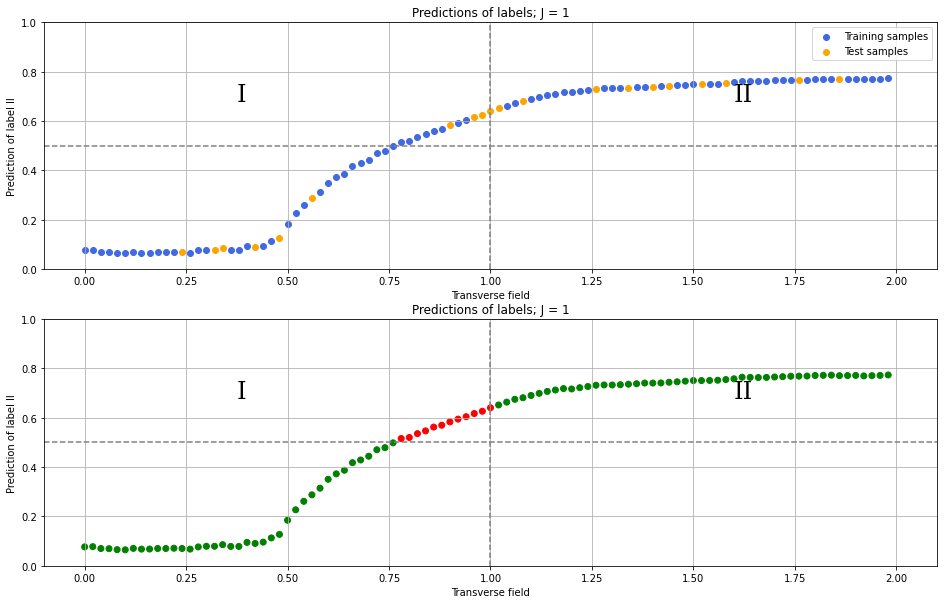

In [113]:
plot_results_classification(data, train_index, params, 0, N, 
                                vqe_conv_noise = 0.001, vqe_rot_noise = 0.001, qcnn_conv_noise = 0.001, qcnn_pool_noise = 0.001)

In [8]:
N = 4

dev_vqe_default = qml.device('default.qubit', wires = N, shots = None)
dev_vqe_mixed   = qml.device("default.mixed", wires = N, shots = None)

In [9]:
@qml.qnode(dev_vqe_mixed)
def qcnn_circuit(params_vqe, vqe_shift_invariance, params, N, vqe_conv_noise = 0, vqe_rot_noise = 0, qcnn_conv_noise = 0, qcnn_pool_noise = 0):
    qcnn(params_vqe, vqe_shift_invariance, params, N, vqe_conv_noise, vqe_rot_noise, qcnn_conv_noise, qcnn_pool_noise)
    
    return qml.probs(wires = N - 1)

In [32]:
drawer = qml.draw(qcnn_circuit)
print(drawer([0]*100,0,[0]*num_params_qcnn(N), N,vqe_conv_noise= 0.3, vqe_rot_noise = 0.2, qcnn_conv_noise = 0.5, qcnn_pool_noise = 0.1))

0: ──RY(0.00)──PhaseFlip(0.20)──BitFlip(0.20)──RX(0.00)──PhaseFlip(0.20)──BitFlip(0.20)─╭C
1: ──RY(0.00)──PhaseFlip(0.20)──BitFlip(0.20)──RX(0.00)──PhaseFlip(0.20)──BitFlip(0.20)─╰X
2: ──RY(0.00)──PhaseFlip(0.20)──BitFlip(0.20)──RX(0.00)──PhaseFlip(0.20)──BitFlip(0.20)───
3: ──RY(0.00)──PhaseFlip(0.20)──BitFlip(0.20)──RX(0.00)──PhaseFlip(0.20)──BitFlip(0.20)───

────────────────────────────────────────────────────────────────────────────────────────
───PhaseFlip(0.30)──BitFlip(0.30)─╭C────────────────────────────────────────────────────
──────────────────────────────────╰X──PhaseFlip(0.30)──BitFlip(0.30)─╭C─────────────────
─────────────────────────────────────────────────────────────────────╰X──PhaseFlip(0.30)

──────────────────||──RY(0.00)──PhaseFlip(0.20)──BitFlip(0.20)──RX(0.00)──PhaseFlip(0.20)
──────────────────||──RY(0.00)──PhaseFlip(0.20)──BitFlip(0.20)──RX(0.00)──PhaseFlip(0.20)
──────────────────||──RY(0.00)──PhaseFlip(0.20)──BitFlip(0.20)──RX(0.00)──PhaseFlip(0.20)
───BitFl

In [6]:
# Load data and separate in training and test set
data = joblib.load('./vqe_states_job/vqe_params_0noise.job')

print('Size of Data Set: {0}'.format(len(data)))

train_index = np.sort(np.random.choice(np.arange(len(data)), size=int(0.8*len(data)), replace=False ))

X_train, Y_train = [], []
X_test, Y_test   = [], []

for i in range(len(data)): 
    if i in train_index:
        X_train.append(data[i][0])
        Y_train.append(data[i][1])
    else:
        X_test.append(data[i][0])
        Y_test.append(data[i][1])
        
#X_train, Y_train = jnp.array(X_train), jnp.array(Y_train)
#X_test, Y_test   = jnp.array(X_test), jnp.array(Y_test)

print('______________________________')
print('Size of Training Set: {0}'.format(np.shape(X_train)[0]))
print('Size of Test Set    : {0}'.format(np.shape(X_test)[0]))


Size of Data Set: 100
______________________________
Size of Training Set: 80
Size of Test Set    : 20


In [445]:
vqe_params = X_train[0]
qcnn_params = [0]*25

qcnn_circuit(vqe_params, 0, qcnn_params, 4, 0.001 ,0.001 ,0.001 ,0.001 )

tensor([1., 0.], requires_grad=True)

In [131]:
qcnn_fun = lambda vqe_params, qcnn_params : qcnn_circuit(vqe_params, 0, qcnn_params, 4, 0 ,0 ,0 ,0 )

In [40]:
qcnn_fun([0]*100, [0]*num_params_qcnn(4))

tensor([1., 0.], requires_grad=True)

In [51]:
cost_fn(X_train, Y_train, qcnn_fun, [0]*num_params_qcnn(4))

230.63950029378222